Modified from https://github.com/djk2120/CLM5PPE/blob/master/pyth/whittaker.ipynb

# Set up workspace

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm

In [2]:
import geopandas as gpd
from shapely.geometry import *

# Load data

In [3]:
temperature=xr.open_mfdataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/lnd/proc/tseries/'+
                              '*.TBOT.nc')
GPP=xr.open_mfdataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/lnd/proc/tseries/'+
                              '*.GPP.nc')
RAIN=xr.open_mfdataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/lnd/proc/tseries/'+
                              '*.RAIN.nc')
#RAIN=xr.open_mfdataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/lnd/proc/tseries/'+
#                              '*.RAIN_FROM_ATM.nc')
#snow=xr.open_mfdataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/lnd/proc/tseries/'+
#                              '*.SNOW.nc')

# Define functions

In [6]:
def byhand(t,p):
    t1 = -5  #    tundra-boreal
    t2 =  3  #    boreal-temperate
    t3 = 20  # temperate-tropical

    tvals = [-np.inf,t1,t2,t3,np.inf]
    bvals = [9,8,4,1]


    for i in range(4):
        if (t>tvals[i])&(t<=tvals[i+1]):
            b = bvals[i]

    td = 15; pd=60; bd=3  #desert
    if (t>td)&(p<pd):
        b = bd

    return b

In [7]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

# Process data

In [29]:
fp = './whit/Whittaker_biomes.shp'
data = gpd.read_file(fp)
og   = data.biome_id.copy(deep=True).values

In [30]:
newb = np.array([9,8,7,6,5,4,1,2,3])
data.biome_id=newb #more logical order

In [60]:
df0 = pd.read_csv('./whit/Whittaker_biomes.csv')
df = pd.read_csv('./whit/Whittaker_biomes.csv')
x  = df.biome_id.values 

In [62]:
for i in 1+np.arange(9):
    ix = df0.biome_id==i
    b  = newb[og==i]
    x[ix]=b
df.biome_id=x

In [33]:
#(mm/s) => (mm/s)*(s/min)*(min/hr)*(hr/day)*(days/yr)*(cm/mm)
#60*60*24*365/10

In [34]:
tbot = (temperature.TBOT).mean(dim='time').compute()-273.15  #degC
gpp=(24*60*60*GPP.GPP).groupby('time.year').mean().mean(dim='year').compute() #gC/m2/yr
prec = (60*60*24*365/10*RAIN.RAIN).groupby('time.year').mean().mean(dim='year').compute()  #cm/yr

In [35]:
tbot_flat=tbot.values.ravel()
gpp_flat=gpp.values.ravel()
prec_flat=prec.values.ravel()

#tbot_flat=tbot_flat[~np.isnan(tbot_flat)]
#gpp_flat=gpp_flat[~np.isnan(gpp_flat)]
#prec_flat=prec_flat[~np.isnan(prec_flat)]

In [36]:
latgrid=np.tile(tbot.lat,(144,1)).transpose()
longrid=np.tile(tbot.lon,(96,1))
latgrid_flat=latgrid.ravel()
longrid_flat=longrid.ravel()

# Calculate biomes

In [37]:
bclass = np.zeros(np.size(tbot_flat))+np.nan
for i in range(np.size(tbot_flat)):
    if i%1000==0:
        print(i)
    if np.isnan(tbot_flat[i]):
        bclass[i]=np.nan
    elif (tbot_flat[i]<0)&(gpp_flat[i]==0):
        bclass[i]=0  #ice
    else:
        ptf = gpd.GeoDataFrame({'geometry':[Point(tbot_flat[i],prec_flat[i])]})
        x=gpd.overlay(ptf, data, how='intersection')
        if len(x)>0:
            bclass[i] = x.biome_id.values
        else:
            bclass[i] = byhand(tbot_flat[i],prec_flat[i])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


# Make figures

In [38]:
c = np.zeros([10,3])
c[1,:] = [9,91,31]
c[2,:] = [171,215,102]
c[3,:] = [218,203,111]
c[4,:] = [29,196,130]
c[5,:] = [136,246,72]
c[6,:] = [205,108,60]
c[7,:] = [245,245,159]
c[8,:] = [91,56,9]
c[9,:] = [160,211,216]
c = c/256

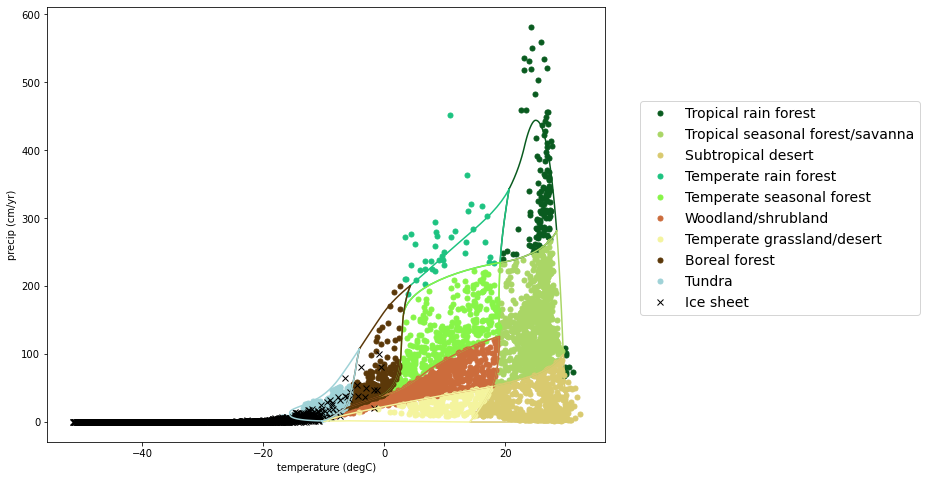

In [69]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
#biomes = np.unique(df.biome_id.values)
ll=[]
for i in 1+np.arange(9):
    ix = bclass==i
    plt.plot(tbot_flat[ix],prec_flat[ix],'.',markersize=10,color=c[i,:])
    ll.append(data.biome[data.biome_id==i].values[0])

ix = bclass==0
plt.plot(tbot_flat[ix],prec_flat[ix],'kx')
ll.append('Ice sheet')

    
plt.legend(ll,bbox_to_anchor = (1.05, 0.8),fontsize=14)
for i in 1+np.arange(9):
    ix = df.biome_id==i
    t = df.temp_c[ix]
    p = df.precp_cm[ix]
    plt.plot(t,p,'-',color=c[i,:])

plt.xlabel('temperature (degC)')
plt.ylabel('precip (cm/yr)');

In [78]:
ll

['Tropical rain forest',
 'Tropical seasonal forest/savanna',
 'Subtropical desert',
 'Temperate rain forest',
 'Temperate seasonal forest',
 'Woodland/shrubland',
 'Temperate grassland/desert',
 'Boreal forest',
 'Tundra',
 'Ice sheet']

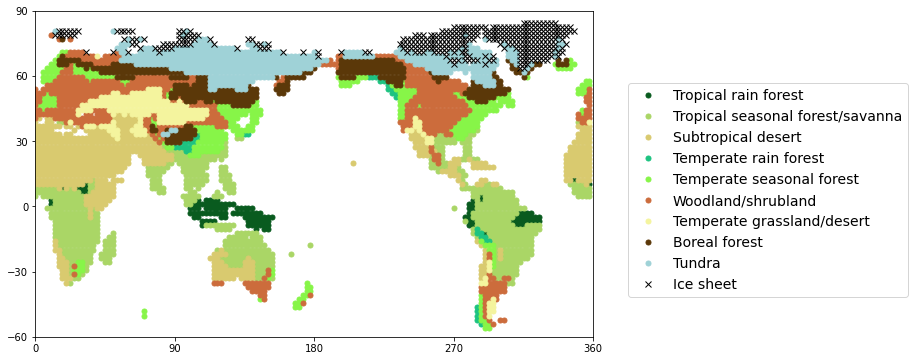

In [70]:
fig = plt.figure(figsize=[10,6])
ll = []
for i in 1+np.arange(9):
    ix = bclass==i
    plt.plot(longrid_flat[ix],latgrid_flat[ix],'.',color=c[i,:],markersize=10)
    ix = data.biome_id==i
    ll.append(data.biome[ix].values[0])
ix = bclass==0
plt.plot(longrid_flat[ix],latgrid_flat[ix],'kx')
ll.append('Ice sheet')
plt.legend(ll,bbox_to_anchor = (1.05, 0.8),fontsize=14)
plt.ylim([-60,90])
plt.xlim([0,360])
plt.yticks(-60+30*np.arange(6))
plt.xticks(90*np.arange(5));

# Make mapping dataset to save

In [71]:
biomedata=bclass.reshape(np.shape(tbot))

In [72]:
da = xr.DataArray(
    data=biomedata,
    dims=["lat", "lon"],
    coords=dict(
        lon=(prec.lon),
        lat=(prec.lat),
    ),
    attrs=dict(
    ),
)

In [73]:
temperature['BCLASS']=da

In [74]:
bclass_netcdf=temperature.drop(['TBOT','time_bounds'])

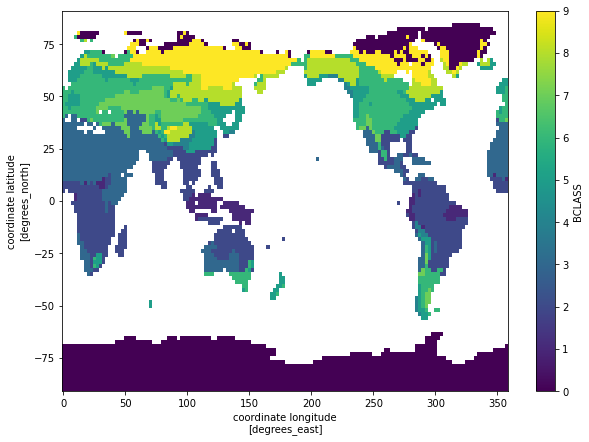

In [76]:
bclass_netcdf.BCLASS.plot(figsize=(10,7))

In [77]:
bclass_netcdf.to_netcdf('whitakker_map.nc')